# Hyper-minimization of deterministic finite state automata

### Imports

In [2]:
from automata.fa.dfa import DFA

### Practical example

Below is defined the original DFA on which the hyper minimization will be performed (example from [Hyper Minimization in O(n^2)](https://www.worldscientific.com/doi/abs/10.1142/S012905410900684X)):

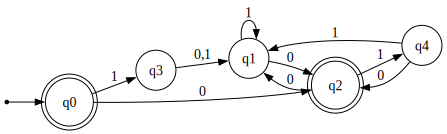

In [3]:
dfa = DFA(
  states={'q0', 'q1', 'q2', 'q3', 'q4'},
  input_symbols={'0', '1'},
  transitions={
    'q0': {'0': 'q2', '1': 'q3'},
    'q1': {'0': 'q2', '1': 'q1'},
    'q2': {'0': 'q1', '1': 'q4'},
    'q3': {'0': 'q1', '1': 'q1'},
    'q4': {'0': 'q2', '1': 'q1'}
  },
  initial_state='q0',
  final_states={'q2', 'q0'}
)
dfa

A brief look at the minimized (in the standard way) automaton:

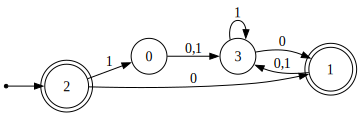

In [4]:
dfa.minify()

### Badr-Geffert-Shipman Algorithm 

#### Introduction

The first implemented algorithm is the one descrived in the [original paper](http://www.numdam.org/article/ITA_2009__43_1_69_0.pdf) regarding the hyper minimization of DFAs by Andrew Badr, Viliam Geffert and Ian Shipman.

This algorithm can be broken down in the following high-level steps:
- minimization (in the standard way i.e. using Hopcroft (preferred) or Brzozowski) of the input DFA
- identification of the states in the kernel and in the preamble
- collapse of the preamble states into other state in the same almost-equivalence class

More in detail, the algorithm works by performing a pre-processing to facilitate the operation of identifying the kernel states through the construction of a matrix $E$, the generic element $e_{i,j}$ is assigned as follows:

$$
\begin{equation*}
e_{i,j} =
  \begin{cases}
  1 \text{ if the state $q_j$ can be reached from the state $q_j$ with a path of length $> 0$} \\
  0 \text{ otherwise}
  \end{cases}
\end{equation*}
$$

Next, builds a $K$ vector where the $i$-th element, corresponding to the $q_i$ state, is $1$ if the $i$-th state is in the kernel, $0$ otherwise, this task is accomplished by checking the elements of the matrix $E$, more precisely, the generic element $k_{i}$ is assigned as follows:

$$
\begin{equation*}
k_{i} =
  \begin{cases}
  1 \text{ if $e_{1,j} = e_{j,j} = e_{j, i} = 1$ } \\
  0 \text{ otherwise}
  \end{cases}
\end{equation*}
$$

Finally, the algorithm calculates the almost-equivalence classes and collapses the preamble states into a kernel state if the almost-equivalence class contains both kernel and preamble states or collapses the preamble states into a non-kernel state if the almost-equivalence class contains only preamble states.

This last step is performed constructing a $P$ vector that associates to each state $q_i$ the set of the partition to which it belongs.

Initially, the partition is defined as follows: $P = \{ \{q_1\}, \{q_2\}, \dots, \{q_n\} \}$, then the algorithm iterates over the states and for each couple of states $q_i$ and $q_j$ checks if they are in the same almost-equivalence class, if they are, the algorithm merges the partitions to which they belong, mathematically, the almost-equivalence of two states not known to be almost-equivalent is checked as follows:

$$q_{i} \sim q_{j} \iff \forall \alpha \in \Sigma \quad \delta(q_{i}, \alpha), \delta(q_{j}, \alpha) \in Q_\alpha$$

#### Implementation

First of all, the `path_length` function is defined below, which calculates the length of the shortest path connecting two states within the automaton.

The function essentially performs a Breadth-First Search and requires $O(n \times m)$ time with $n$ the number of states of the automaton and $m$ the number of symbols in the alphabet accepted by the automaton.

In [5]:
# returns the length of the shortest path between two states, or -1 if no path exists
def path_length(dfa: DFA, initial, target):
  visited = set()
  queue = [{'state': initial, 'length': 0}]

  while queue:
    current = queue.pop(0)
    visited.add(current['state'])

    if current['state'] == target:
      return current['length']

    for state in dfa.transitions[current['state']].values():
      if state not in visited:
        queue.append({'state': state, 'length': current['length'] + 1})

  return -1

Next, the `bgs_hyper_minimize` function is defined, which implements the Badr-Geffert-Shipman algorithm, following the steps described above.

In [6]:
def bgs_hyper_minimize(dfa: DFA):
  # Step 1: minimization of the DFA
  minimal_dfa = dfa.minify()

  # Step 2 (pre-processing): analysis of the reachability in the transition graph (construction of the E matrix)
  E = [[path_length(minimal_dfa, x, y) > 0 for y in minimal_dfa.states] for x in minimal_dfa.states]

  # Step 3: kernel states identification

  # K[i] contains true if q_i is a kernel state, initially all states are considered as preamble states
  K = [0] * len(minimal_dfa.states)
  # iterate over the states to find the kernel states
  for i in range(len(minimal_dfa.states)):
    for j in range(len(minimal_dfa.states)):
      if E[1][j] and E[j][j] and E[j][i]: # condition to be a kernel state, refer to the paper for the explanation
        K[i]['kernel'] = True
        # no need to check further for this state
        break

  # Step 4: almost-equivalence relation computation

  # initial partitioning of the states Q = {q_1} ∪ {q_2} ∪ ... ∪ {q_n}
  P = [i for i in range(len(minimal_dfa.states))]
  # n-1 iterations needed to find all the almost-equivalence relations
  for _ in range(1, len(minimal_dfa.states)):
    # search for almost-equivalent states i.e. couples of states q_i1 and q_i2, with i1 ≠ i2, that
    # are not already in the same set of the partition P but are almost-equivalent
    for i1_i, i1_s in enumerate(minimal_dfa.states):
      for i2_i, i2_s in enumerate(minimal_dfa.states):
        if P[i1_i] != P[i2_i]:
          # check if the states are almost-equivalent
          almost_equivalent = True
          for symbol in minimal_dfa.input_symbols:
            next_q_i1 = minimal_dfa.transitions[i1_s][symbol]
            next_q_i2 = minimal_dfa.transitions[i2_s][symbol]

            if P[next_q_i1] != P[next_q_i2]:
              almost_equivalent = False
              break

          # if the states are almost-equivalent, merge the sets
          if almost_equivalent:
            P[i2_i] = P[i1_i]

  # Step 5: hyper-minimization of the DFA (useless states removal)
            
  # hyper-minimal DFA attributes initialization
  hyperminimal_states = set(minimal_dfa.states)                           # states
  hyperminimal_transitions = dict(minimal_dfa.transitions)                # transitions
  for key in hyperminimal_transitions.keys():                             # deep copy of the transitions
    hyperminimal_transitions[key] = dict(hyperminimal_transitions[key])   
  hyperminimal_initial_state = minimal_dfa.initial_state                  # initial state
  hyperminimal_final_states = set(minimal_dfa.final_states)               # final states

  # iterates over the sets of the partition
  for p_set in range(len(P)):

    # computes the preamble and kernel states of the current set of the partition
    kernels, preambles = [], []
    for i, state in enumerate(minimal_dfa.states):
      if P[i] == p_set: # state belongs to the current set
        if K[i]: # kernel state
          kernels.append(state)
        else: # preamble state
          preambles.append(state)

    # selects the state to which the preamble states will be redirected
    redirect_state = None
    if len(preambles) != 0: # if not, means that the set is composed only of kernel states so no state can be removed
      if len(kernels) != 0: # current set contains both preamble and kernel states
        redirect_state = kernels[0] # redirect state is a kernel state (arbitrary choice, first for semplicity)
      else:
        redirect_state = preambles[0] # redirect state is a preamble state (arbitrary choice, first for semplicity)
        preambles = preambles[1:] # remove the state from the preamble states list so it is not redirected to itself

    # removes the useless states
    for state in preambles:
      hyperminimal_states.remove(state)   # state is removed from the set of states
      del hyperminimal_transitions[state] # transitions from the state are removed

      # redirects the edges going into the removed state to the redirect state
      for hm_state in hyperminimal_states:
        for symbol in minimal_dfa.input_symbols:
          if hyperminimal_transitions[hm_state][symbol] == state:
            hyperminimal_transitions[hm_state][symbol] = redirect_state

      # finally, if the removed state was the initial state, the redirect state becomes the new initial state
      # and if the removed state was a final state, the redirect state becomes a final state and the removed state is
      # removed from the final states set
      if state == hyperminimal_initial_state:
        hyperminimal_initial_state = redirect_state
      if state in hyperminimal_final_states:
        hyperminimal_final_states.remove(state)
        hyperminimal_final_states.add(redirect_state)
  
  # creates and returns the hyper-minimal DFA
  return DFA(
    states=hyperminimal_states,
    input_symbols=set(minimal_dfa.input_symbols),
    transitions=hyperminimal_transitions,
    initial_state=hyperminimal_initial_state,
    final_states=hyperminimal_final_states
  )

The algorithm can be seen at work in the following cell.

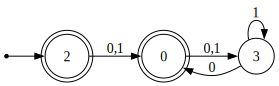

In [7]:
bgs_hyper_minimize(dfa)

#### Complexity

A brief note about the notation used in the following complexity analysis:
- $n$ is the number of states of the automaton
- $m$ is the number of symbols in the alphabet accepted by the automaton

The first step of the alorithm uses the Hopcroft minimization algorithm, which is well-known to have a time complexity of $O(n \times m)$.

The second step of the algorithm constructs the matrix $E$, which executes O(n^2) iterations, each of which requires $O(n \times m)$ time, thus the overall time complexity of this step is $O(n^3 \times m)$.

The third step of the algorithm constructs the vector $K$, which uses two nested loops, each of executes $O(n)$ iterations, thus the overall time complexity of this step is $O(n^2)$.

The fourth step of the algorithm constructs the vector $P$, which uses four nested loops, three of which execute $O(n)$ iterations and the last one executes $O(m)$ iterations, thus the overall time complexity of this step is $O(n^3 \times m)$.

The overall time complexity of the algorithm is $O(n^3 \times m)$.

### Badr Algorithm 

#### Introduction

The second implemented algorithm is the one described in [this paper](https://www.andrewbadr.com/files/hyper/ciaa32.pdf) by Andrew Badr.

This algorithm follows the same high-level steps as the previous one, but it differs in the way the almost-equivalence classes are calculated.

Following the paper, the algorithm is broken down in sub-functions each one performing a specific task (more details below):
- `xor_cross_product`
- `right finite states`
- `f_equivalence_classes`
- `f_merge_states`

```xor_cross_product``` implements the XOR cross product of two automata.

More mathematically, the XOR cross product of two automata $D_1 = (Q_1, \Sigma, \delta_1, q_{I_1}, A_1)$ and $D_2 = (Q_2, \Sigma, \delta_2, q_{I_2}, A_2)$ is the automaton $D^\otimes$ such that $D^\otimes = (Q^\otimes, \Sigma, \delta^\otimes, q_I^\otimes, A^\otimes)$ where:
- $Q^\otimes = \{ (q_1, q_2) \space : \space q_1 \in Q_1 \space \wedge \space q_2 \in Q_2 \}$
- $\forall q_1 \in Q_1, \space \forall q_2 \in Q_2, \space \forall c \in \Sigma \space : \space \delta^\otimes((q_1, q_2), c) = (\delta_1(q_1, c), \delta_2(q_2, c))$
- $q_I^\otimes = (q_{I_1}, q_{I_2})$
- $A^\otimes = \{ (q_1, q_2) \space : \space (q_1 \in A_1) \space \otimes \space (q_2 \in A_2) \}$

In [57]:
def xor_cross_product(dfa_1: DFA, dfa_2: DFA):
  # computes the states set of the cross product DFA
  states = set()
  for q_1 in dfa_1.states:
    for q_2 in dfa_2.states:
      states.add((q_1, q_2))

  # computes the transitions of the cross product DFA
  transitions = dict()
  for q_1 in dfa_1.states:
    for q_2 in dfa_2.states:
      transitions[(q_1, q_2)] = dict()
      for symbol in dfa_1.input_symbols:
        transitions[(q_1, q_2)][symbol] = (dfa_1.transitions[q_1][symbol], dfa_2.transitions[q_2][symbol])

  # computes the final states of the cross product DFA
  finals = set()
  for q in states:
    if q[0] in dfa_1.final_states and q[1] not in dfa_2.final_states:
      finals.add(q)
    elif q[0] not in dfa_1.final_states and q[1] in dfa_2.final_states:
      finals.add(q)
  
  # creates and returns the cross product DFA
  return DFA(
    states=states,
    input_symbols=set(dfa_1.input_symbols),
    transitions=transitions,
    initial_state=(dfa_1.initial_state, dfa_2.initial_state),
    final_states=finals
  )

```right_finite_state```

In [41]:
def right_finite_state(dfa: DFA, S: set):
  # computes S' = Q \ S
  S_prime = set([q for q in dfa.states if q not in S])

  # initializes the incoming and outgoing edges sets for each state
  incoming, outgoing = dict(), dict()
  for q in dfa.states:
    incoming[q] = set()
    outgoing[q] = set()

  # computes the incoming and outgoing edges for each state in S'
  for q in S_prime:
    for c in dfa.input_symbols:
      q_prime = dfa.transitions[q][c]
      incoming[q_prime].add((q, c))
      outgoing[q].add((q_prime, c))

  # computes the subset F of Q of all states that induce a finite language
  F = list()
  to_process = list(S)
  while to_process:
    q = to_process.pop(0)
    F.append(q)
    
    for q_prime, c in incoming[q]:
      outgoing[q_prime].remove((q, c))
      if not outgoing[q_prime]:
        to_process.append(q_prime)

  return F

```uninon_find```

In [42]:
class QuickUnion:
    def __init__(self):
        # Initialize the parent dictionary
        self.parent = {}

    def make_set(self, x):
        self.parent[x] = x

    def find(self, x):
        """
        Find the root of the tree containing object x.
        """
        if x not in self.parent:
            return None
        
        while x != self.parent[x]:
            x = self.parent[x]
        return x

    def union(self, x, y):
        """
        Merge the trees containing objects x and y.
        """
        root_x = self.find(x)
        root_y = self.find(y)
        
        if root_x is None or root_y is None:
            return
        
        if root_x != root_y:
            self.parent[root_x] = root_y

    def connected(self, x, y):
        """
        Check if objects x and y belong to the same set.
        """
        return self.find(x) == self.find(y)
    
    def iterate_sets(self):
        """
        Iterate over the partition sets and yield each set as a list of objects.
        """
        sets = {}
        
        for obj in self.parent:
            root = self.find(obj)
            if root not in sets:
                sets[root] = []
            sets[root].append(obj)
        
        for objs in sets.values():
            yield objs

In [43]:
def f_equivalence_classes(dfa: DFA):
  # computes the cross-product of the DFA with itself
  D_xor = xor_cross_product(dfa, dfa)
  
  # computes the set S = {(q, q) | q ∈ Q} which is the set of all self-pair states in the cross-product
  S = set()
  for q in dfa.states:
    S.add((q, q))

  # 
  F = right_finite_state(D_xor, S)

  P = QuickUnion()
  for q in dfa.states:
    P.make_set(q)
  for q, r in F:
    P_q = P.find(q)
    P_r = P.find(r)
    if P_q != P_r:
      P.union(P_q, P_r)
  
  return P

```preamble and kernel```

In [44]:
def preamble_and_kernel(dfa: DFA):
  K = set()

  # TODO: can be optimized just a fast implementation to let the code work
  R = [set() for _ in range(len(dfa.states))]
  for i, q in enumerate(dfa.states):
    for r in dfa.states:
      if path_length(dfa, q, r) > 0:
        R[i].add(r)

  for i, q in enumerate(dfa.states):
    if q in R[i]:
      K = K.add(q)

  return (set(dfa.states) - K, K)

```f_merge_states```

In [51]:
def f_merge_states(dfa: DFA, E: QuickUnion, P: set, K: set):
  # hyper-minimal DFA attributes initialization
  hyperminimal_states = set(dfa.states)                           # states
  hyperminimal_transitions = dict(dfa.transitions)                # transitions
  for key in hyperminimal_transitions.keys():                     # deep copy of the transitions
    hyperminimal_transitions[key] = dict(hyperminimal_transitions[key])   
  hyperminimal_initial_state = dfa.initial_state                  # initial state
  hyperminimal_final_states = set(dfa.final_states)               # final states

  for S in E.iterate_sets():
    S = set(S)
    P_S = S.intersection(P)
    K_S = S.intersection(K)
    if K_S:
      R = K_S.pop()
    else:
      R = P_S.pop()
    for q in P_S:
      # merge q into R
      hyperminimal_states.remove(q)   # state is removed from the set of states
      del hyperminimal_transitions[q] # transitions from the state are removed

      # redirects the edges going into the removed state to the redirect state
      for hm_state in hyperminimal_states:
        for symbol in dfa.input_symbols:
          if hyperminimal_transitions[hm_state][symbol] == q:
            hyperminimal_transitions[hm_state][symbol] = R

      # finally, if the removed state was the initial state, the redirect state becomes the new initial state
      # and if the removed state was a final state, the redirect state becomes a final state and the removed state is
      # removed from the final states set
      if q == hyperminimal_initial_state:
        hyperminimal_initial_state = R
      if q in hyperminimal_final_states:
        hyperminimal_final_states.remove(q)
        hyperminimal_final_states.add(R)

  # creates and returns the hyper-minimal DFA
  return DFA(
    states=hyperminimal_states,
    input_symbols=set(dfa.input_symbols),
    transitions=hyperminimal_transitions,
    initial_state=hyperminimal_initial_state,
    final_states=hyperminimal_final_states
  )

In [52]:
def badr_hyper_minimize(dfa):
  # Step 1: minimization of the DFA
  minimal_dfa = dfa.minify()

  # Step 2: equivalence classes computation
  E = f_equivalence_classes(minimal_dfa)

  # Step 3: preamble and kernel states identification
  P, K = preamble_and_kernel(minimal_dfa)

  # Step 4: states merging
  return f_merge_states(minimal_dfa, E, P, K)

{(0, 1): set(), (1, 2): set(), (2, 1): set(), (0, 0): set(), (3, 1): {((0, 3), '0'), ((1, 2), '0'), ((0, 2), '0'), ((1, 3), '0')}, (1, 1): {((2, 3), '0'), ((3, 2), '0')}, (0, 3): {((2, 1), '1'), ((2, 0), '1'), ((2, 3), '1')}, (2, 0): set(), (3, 0): {((3, 2), '1'), ((1, 2), '1'), ((0, 2), '1')}, (2, 3): set(), (0, 2): set(), (3, 3): {((1, 3), '1'), ((0, 1), '0'), ((0, 3), '1'), ((0, 1), '1'), ((1, 0), '0'), ((1, 0), '1'), ((3, 1), '1'), ((3, 0), '1')}, (2, 2): set(), (1, 0): set(), (3, 2): set(), (1, 3): {((3, 0), '0'), ((2, 0), '0'), ((2, 1), '0'), ((3, 1), '0')}}
{(0, 1): {((3, 3), '1'), ((3, 3), '0')}, (1, 2): {((3, 0), '1'), ((3, 1), '0')}, (2, 1): {((1, 3), '0'), ((0, 3), '1')}, (0, 0): set(), (3, 1): {((3, 3), '1'), ((1, 3), '0')}, (1, 1): set(), (0, 3): {((3, 3), '1'), ((3, 1), '0')}, (2, 0): {((1, 3), '0'), ((0, 3), '1')}, (3, 0): {((3, 3), '1'), ((1, 3), '0')}, (2, 3): {((1, 1), '0'), ((0, 3), '1')}, (0, 2): {((3, 0), '1'), ((3, 1), '0')}, (3, 3): set(), (2, 2): set(), (1, 0): 

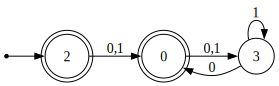

In [53]:
badr_hyper_minimize(dfa)

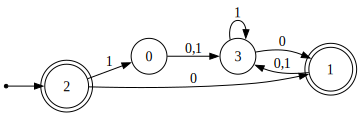

In [18]:
dfa.minify()

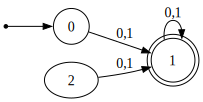

In [56]:
DFA(
  states={0,1},
  input_symbols={'0', '1'},
  transitions={
    0: {'0': 1, '1': 1},
    1: {'0': 1, '1': 1},
    2: {'0': 1, '1': 1},
  },
  initial_state=0,
  final_states={1}
)

### Holzer-Maletti Algorithm

The last implemented algorithm, the one with the best time complexity